# Language Knowledge (Vocabulary)
Duration: 30 minutes
Content: This section tests your knowledge of Japanese vocabulary, including kanji readings, orthography, word formation, contextually-defined expressions, paraphrases, and usage
It mainly composes following five categories:
- ``Reading Kana`` (Pronunciation Questions): Given a kanji word, choose the correct kana reading.
- `Writing Kanji` (Writing Questions): Given a word written in kana, choose the correct kanji representation.
- `Word Meaning` Selection (Vocabulary Understanding): Choose the most suitable word to fill in the sentence from four options.
- `Synonym Replacement`: Select a word that has the same or similar meaning as the underlined word.
- `Vocabulary Usage`: Assess the usage of words in actual contexts, choosing the most appropriate word usage, including some common Japanese expressions or fixed phrases.

In [28]:
import pandas as pd
import json
import os
import random
import pickle
import re
import uuid
from typing import *
from langchain_openai import AzureOpenAI,AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.embeddings import XinferenceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from IPython.display import display, Markdown, Latex
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,RemoveMessage,HumanMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional
from langchain_tavily import TavilySearch
from langchain.schema import Document
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from Libs.LLMs import azure_llm, aws_llm
load_dotenv()

True

In [29]:
# Import N3 Vocabulary
file_path = '../../Vocab/n3.csv'
# Read the CSV file
data = pd.read_csv(file_path)
words = data.iloc[:, :2].sample(frac=1).reset_index(drop=True)
# Display the content of the CSV file
words.head()
vocab_dict = words.set_index(words.columns[0])[words.columns[1]].to_dict()
vocab_dict = json.dumps(vocab_dict, ensure_ascii=False, separators=(',', ':'))

#### load Models

#### Exam Paper Outline
### A. overall thinking the structure of an exam
1. distribution of the difficulty 
2. topics
3. reasoning

## Data Strcuture

# Kanji 读假名（读音问题）

In [30]:
def online_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    print("---WEB SEARCH---")
    
    topic = state['messages'][0].content
    
    tavily_search_tool = TavilySearch(
        max_results=5,
        topic="news",
        days=1
    )
    # Web search
    docs = tavily_search_tool.invoke({"query": topic})
    
    print(docs)

    web_results = "\n".join([d["content"] for d in docs["results"]])
    
    print("Web results: ", web_results)

    return {"documents": web_results, "topic": topic}

In [31]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class QuestionState(TypedDict):
    topic: str
    question: str
    documents: str
    messages: Annotated[list, add_messages]


example = """
問題5
つぎのことばの使い方として最もよいものを、1・2・3・4から一つえらびなさい。
31. 内容
	1.	修理のため、エアコンの内容を一度取り出します
	2.	鍋の中にカレーの内容を入れて、1時間くらい煮てください
	3.	古い財布から新しい財布へ内容を移しました
	4.	この手紙の内容は、ほかの人には秘密にしてください

32. 活動
	1.	彼は有名なロック歌手だったが、今は活動していない
	2.	山に登ると、新鮮な空気が活動していて気持ちがいい
	3.	さっきまで活動していたパソコンが、急に動かなくなった
	4.	駅前のコンビニは24時間活動しているので便利だ

33. 落ち着く
	1.	この辺りは、冬になると雪が落ち着いて、春になるまで溶けません
	2.	シャツにしみが落ち着いてしまって、洗ってもきれいになりません
	3.	あそこの木の上に美しい鳥が落ち着いています
	4.	大好きなこの曲を聞くと、いつも気持ちが落ち着きます

34. ぐっすり
	1.	遠慮しないで、ぐっすり食べてください
	2.	優勝できたのは、毎日ぐっすり練習したからだと思う
	3.	今日は疲れているので、朝までぐっすり眠れそうだ
	4.	古い友人と久しぶりに会って、ぐっすりおしゃべりした

35. 性格
	1.	日本の古い性格に興味があるので、神社やお寺によく行きます
	2.	森さんはおとなしい性格で、自分の意見はあまり言いません
	3.	値段が高くても、塗装で性格のいい車を買うつもりです
	4.	音楽の性格を伸ばすために、5歳から専門家の指導を受けました
"""

# Nodes
def question_draft_generator(state: QuestionState):
    """First LLM call to generate initial question"""
    print("---Generator----")
        
    search_result = state['documents'],
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
                    You are a japanese teacher. Your job is disordered sentences require selecting the correct arrangement order.
                    The vocabulary should be restricted to N3 level, use the vocabulary in the `Dictionary` as much as you can.
                    Please refer to the question examples following the formal exam paper. please highlight the word to ask candidate with <u><em></em></u>.
                    Append the correct answer and explanation of the main challenges on why the teacher asks this question to the candidate  at each question.
                    Finally, output beautiful markdown format.
                    Dictionary: {vocab_dict}
                    Search result: {search_result}
                    Formal exam paper: {example}
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    
    input = { "topic" : state['topic'],
              "search_result": search_result, 
              "vocab_dict": vocab_dict,
              "example": example,
              "messages": state["messages"]
              }
    # final_message = prompt.format_messages(**input)
    # print(final_message)
    
    generate = prompt | azure_llm
    
    msg = generate.invoke(input=input)
    
    
    return {"question": msg.content, "messages": [AIMessage(content=msg.content)] }


def reflection_node(state: QuestionState) -> QuestionState:
    print("---REVISOR---")
    
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]

    reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """you are a Japanese language educator reviewing a JLPT exam paper. Generate critique and recommendations for the user's submission.
            the review focuses on content accuracy and question quality. 
            - For content accuracy, you must verify that the grammar and vocabulary questions accurately reflect the appropriate JLPT N3 level, ensuring the reading passages are clear, relevant, and appropriately challenging. 
            - For question quality, you must ensure all questions are clearly worded and free from ambiguity to comprehensively assess different language skills, and confirm that the difficulty level of the questions matches the intended JLPT N3 level.
            - During detailed refinement, you check the format and presentation of the paper, ensuring it is well-organized and the instructions are clear and concise. you also ensure the content is culturally appropriate and relevant to Japanese language and culture.
            - Finally, you make give feedback, providing detailed recommendations, including requests.If you think the exam paper is good enough, you just say "GOOD ENOUGH"
            """
        ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    reflect = reflection_prompt | azure_llm
    
    res = reflect.invoke(translated)
    
    print(res.content)
    
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}



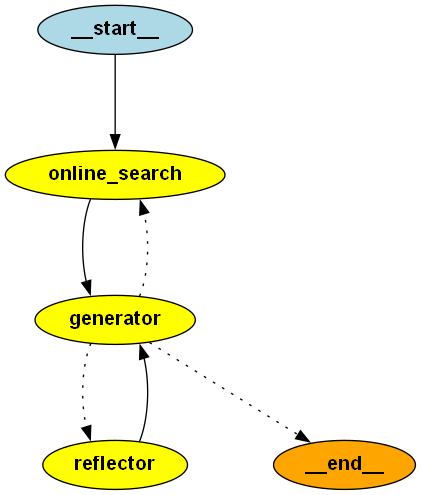

In [32]:
# Build workflow
builder = StateGraph(QuestionState)

builder.add_node("online_search", online_search)
builder.add_node("generator", question_draft_generator)
builder.add_node("reflector", reflection_node)
# Add nodes

def should_continue(state: QuestionState):
    if len(state["messages"]) > 3: 
        print("--- Reach the Maximum Round ---")
        return END
        if state["messages"][-1] == "GOOD ENOUGH":
            print("--- AI Reviser feels Good Enough ---")
            return END
    return "reflector"

# Add edges to connect nodes
builder.add_edge(START, "online_search")
builder.add_edge("online_search", "generator")
# 
builder.add_conditional_edges("generator", should_continue)
builder.add_edge("reflector", "generator")
memory = MemorySaver()

# Compile
kanji_graph = builder.compile(checkpointer=memory)

# Show workflow
display(Image(kanji_graph.get_graph().draw_png()))

In [33]:
row = words.iloc[1]
word = f"{row[0]}({row[1]})"
word

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21844\878816679.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = f"{row[0]}({row[1]})"


'暖まる(あたたまる)'

In [34]:
# # Debug the Conversation
# for event in kanji_graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content=word
#             )
#         ],
#     },
#     config={"configurable": {"thread_id": "1"}},
# ):
#     print(event)
#     print("---")

In [35]:
kanji = kanji_graph.invoke(
    {
       "messages": [
                HumanMessage(
                    content=word
                )
            ],
        },
    config={"configurable": {"thread_id": "1"}}
)
display(Markdown(kanji["question"]))

---WEB SEARCH---
{'query': '暖まる(あたたまる)', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '暖まる／温まる（あたたまる）とは？ 意味・読み方・使い方をわかりやすく解説 - goo国語辞書', 'url': 'https://dictionary.goo.ne.jp/word/暖まる_(あたたまる)/', 'content': '暖まる／温まる（あたたまる）とは。意味や使い方、類語をわかりやすく解説。[動ラ五（四）]1 熱を受けて程よい温度になる。あったまる。「風呂に入って—・る」「スープが—・る」2 （温まる）心が満ち足りてほのぼのと和やかになる。「心の—・る言葉」3 （暖まる）金回りがよくなる', 'score': 0.89324445, 'raw_content': None}, {'title': '暖まる (アタタマル)とは？ 意味や使い方 - コトバンク', 'url': 'https://kotobank.jp/word/暖まる-425212', 'content': 'デジタル大辞泉 - 暖まるの用語解説 - [動ラ五（四）]1 熱を受けて程よい温度になる。あったまる。「風呂に入って―・る」「スープが―・る」2 （温まる）心が満ち足りてほのぼのと和やかになる。「心の―・る言葉」3 （暖まる）金回りがよくなる。「懐が―・る」[類語]熱する・あ', 'score': 0.83452857, 'raw_content': None}, {'title': '【暖まる】 と 【温まる】 はどう違いますか？ | HiNative', 'url': 'https://ja.hinative.com/questions/22640140', 'content': '暖まる （あたたまる）, 温まる （あたたまる） 暖まる の類義語 暖まる→日差しや空気・気候に使います ストーブをつけると部屋(の空気)が暖まる 南から暖かい風が吹いて来た 温まる→一般的な物・水・人の気持ちなどに使います ストーブの前にいたら体が温まった 寒い日は温泉に入って', 'score': 0.79580134, 'raw_content':

### 改善后的问题：暖まる (あたたまる)

以下的文句需要重新排列顺序，使其成为自然的日语表达。并选择正确答案。

---

#### 文の選択肢:
1. <u><em>暖まる</em></u> 部屋が ストーブをつけて。
2. ストーブをつけて 部屋が <u><em>暖まる</em></u>。
3. 部屋が <u><em>暖まる</em></u> ストーブをつけて。
4. ストーブをつけて <u><em>暖まる</em></u> 部屋が。

---

### 正解:
**2. ストーブをつけて 部屋が 暖まる。**

---

### 解説:
「暖まる」是一个常见的日语动词，用于描述房间或空气通过外界热量的作用变暖的情况。在这个问题中，正确的句子顺序需要符合自然的日语表达规则，即动作（ストーブをつけて）发生在前，而结果（部屋が暖まる）发生在后。

此外，理解「暖まる」和「温まる」的区别也很重要：
- **暖まる**：通常用于描述环境或空气变暖，例如「部屋が暖まる」。
- **温まる**：通常用于描述物体或身体变暖，例如「手が温まる」。

---

### 主な挑戦点:
1. **「暖まる」的正确使用**：考生需要理解这个动词的语境，并能够区分它与「温まる」的不同。
2. **语序的正确排列**：考生需要具备将单词和短语按自然顺序排列的能力，这是日语学习中的重要技能。

---

### 中文解释：
这道题目考察了日语动词「暖まる」的使用方法，以及如何正确排列句子顺序。「暖まる」主要用于描述房间或空气通过加热变暖的情况。考生需要先描述动作「开暖炉」，然后再描述结果「房间变暖」，以符合自然的日语表达顺序。同时，问题还间接测试了考生对「暖まる」和「温まる」的区别理解。

---

### 推荐改进：
1. **添加示例**：在问题说明中加入一个示例，帮助考生理解如何排列句子。例如：
   ```
   例: 「猫が寝ている ソファで」を「ソファで 猫が寝ている」に並べ替えます。
   ```

2. **扩展解说**：在解说中加入更多例句，以帮助考生更好地理解「暖まる」和「温まる」的区别：
   - 暖まる：ストーブをつけると部屋が暖まる。
   - 温まる：寒い日は温泉に入ると体が温まる。

3. **视觉分隔**：使用横线或不同的字体样式，将问题、选项和解说更清晰地分隔开。

---

### 最终评价：
改进后的问题结构清晰，内容丰富，更能帮助考生理解「暖まる」的用法及其语境，非常适合JLPT N3水平的学习者。这是一道优秀的练习题！